# A suggestion of curse changes for a robot sailboat

## Motivation

The goal of this project is to suggest good points to change the curse of a sailboat while going from point $A$ to point $B$.

This project is done as part of the curse "Maschienen Learning" at the University of Applied Sciences South Westphalia. The code labeling the was writen by the team of the [Sailing Team Darmstadt e.V.](https://www.st-darmstadt.de/). A society of stundens whose goal it is to build the ["roBOOTer"](https://www.st-darmstadt.de/ueber-uns/boote/prototyp-ii/) a fully autonomous sailboat able to cross the atlantic ocean. A technical challenge that was mastered the first time only a few years ago by [a Norwegian team](http://sailbuoy.no/). I myself am part of the Sailing Team Darmstadt e.V. for nearly 10 years.

One of the challenges to solve is a highly efficient way to find a path over the Ocean. The boot is only 2 meters long and powered by solar energy. That makes power a relatively spares commodity.

## Situation as is
At the moment the pathfinding algorithm generates a set of more or less random routes to the goal. Each route than gets optimized by a gradient decent moving the curse change points over the ocean to find a path with the lowest cost that can be found by following the highest gradient. This is relatively inefficient since only local minima can be found for each of the randomly generated route. The route with the lowest cost for the so optimized route will be chosen as the final route.
The idea of this project is to ascertain if it is possible to generate a better initial route through a neural network to give the system a kind of good instinct for the initial routes to reduce optimization steps and the number fo routes that need to be calculated to find a good route. Even tough the initial calculation effort could be high the parallel calculation of 40 routes and lots of optimization steps make it possible that some calculation time and therefore energy can be saved this way.
The idea of this project is to ascertain if it is possible to generate a better initial route through a neural network to give the system a kind of good instinct for the initial routes to reduce optimization steps and the number fo routes that need to be calculated to find a good route. Even tough the initial calculation effort could be high the parallel calculation of 40 routes and lots of optimization steps make it possible that some calculation time and energy can be saved this way.

## The Project

The goal of this project is to calculate a good first route. That allows for some simplifications of this problem.

Some solutions and assumptions can be made.
1. The route proposed by this network will not be the final route. This make a somewhat accurate solution good enough.
2. Since the neural network should not learn how to interpret a specific map but the concept of a map the map can be rotated.
This allows the wind to come always from north.
3. Since curse speed is only somewhat proportional to the wind speed a final course may change depending on wind speed not only direction.
These changes are however somewhat small compared to other influences and can hopefully be ignored since later processing of a proposed route should strait these details out.
4. When the wind comes always from the same direction (After map orientation by wind) map and route can be mirrored allowing to use all data twice for each route.
5. Scale does only matter when the curvature of the earth has a significant influence. Allowing for different scaling of the problem for additional training data.

Since there is a solution for this project that only needs some optimisation we can used labeled data to train the network.

### The generell structure

Since

In [1]:
%cd /pyrate/

/pyrate


In [2]:
!pip install tqdm

In [3]:
import os
from typing import Optional, Final
from math import pi
import glob

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union

In [4]:
import experiments
from pyrate.plan.nearplanner.timing_frame import TimingFrame

New Creation of OptimizationParameters
Traceback (most recent call last):
  File "/pyrate/pyrate/plan/nearplanner/holders.py", line 99, in __post_init__
    raise ValueError
ValueError

New Creation of OptimizationParameters
Traceback (most recent call last):
  File "/pyrate/pyrate/plan/nearplanner/holders.py", line 99, in __post_init__
    raise ValueError
ValueError

New Creation of OptimizationParameters
Traceback (most recent call last):
  File "/pyrate/pyrate/plan/nearplanner/holders.py", line 99, in __post_init__
    raise ValueError
ValueError

New Creation of OptimizationParameters
Traceback (most recent call last):
  File "/pyrate/pyrate/plan/nearplanner/holders.py", line 99, in __post_init__
    raise ValueError
ValueError



In [5]:
experiments.optimization_param.n_iter_grad = 50
experiments.optimization_param.verbose = False

In [6]:
SIZE_INNER = 75
SIZE_ROUTE = 100
MIN_DESTINATION_DISTANCE = 25

In [7]:
# https://stackoverflow.com/questions/16444719/python-numpy-complex-numbers-is-there-a-function-for-polar-to-rectangular-co
def polar_to_cartesian(
    radii: np.ndarray,
    angles: np.ndarray,
):
    """Transforms polar coordinates into cartesian coordinates.

    Args:
        radii: A array of radii.
        angles: A array of angles.

    Returns:
        An array of cartesian coordinates.
    """
    return radii * np.exp(2j * angles * np.pi)


def cartesian_to_polar(
    x: np.ndarray,
):
    """Transforms cartesian coordinates into polar coordinates.

    Args:
        x: A set of complex number to be separated into polar coordinates.

    Returns:
        An distance array and an angle array.
    """
    return abs(x), np.angle(x)

In [8]:
def random_polygon(
    radius_mean: float = 2,
    radius_sigma: float = 1.5,
):
    """Generates the simplest of polygons, a triangle with a size described by a random polygon.

    Args:
        radius_mean: The average radius defining a circumcircle of a triangle.
        radius_sigma: The variance of a radius defining a circumcircle of a triangle.

    Returns:
        A single triangle.
    """
    number_of_corners = np.random.randint(3, 10)
    array = polar_to_cartesian(
        np.random.lognormal(radius_mean, radius_sigma),
        np.sort(np.random.rand(number_of_corners)),
    )
    offset = np.random.randint(low=-SIZE_ROUTE, high=SIZE_ROUTE, size=(2,))
    return_values = np.zeros((number_of_corners, 2), dtype=float)
    # return_values[1, :] = np.real(offset)
    return_values[:] = offset
    return_values[:, :] += np.array((np.real(array), np.imag(array))).T
    return Polygon(return_values)
    # return np.array( + offset[0], np.imag(array) + offset[1])


random_polygon().exterior.xy

(array('d', [-65.50420757332208, -76.55152312773095, -82.97120566739389, -67.5016122399309, -65.65710097962439, -56.16635209118213, -65.50420757332208]),
 array('d', [-1.6361878980355904, 2.1647544095886033, -41.64859204427268, -39.57442918008357, -38.466923594894915, -24.08243092784785, -1.6361878980355904]))

In [9]:
print(random_polygon())

POLYGON ((63.172065168381955 65.05706995585822, 61.12737057563318 64.21545450958845, 62.0373348803766 63.827140312951656, 62.1989069555481 63.843527016385394, 62.67755594641929 64.0419229267602, 63.172065168381955 65.05706995585822))


In [10]:
def generate_obstacles(
    seed=None,
    number_of_polygons: int = 40,
    radius_mean: float = 2,
    radius_sigma: float = 1,
) -> dict[str, Polygon]:
    """Generates a set of obstacles from a union of triangles.

    The union of triangles meas that if polygons overlap o polygon containing the union of those polygons is returned.
    Args:
        seed: A seed to generate a set of obstacles from.
        number_of_polygons: The number of polygons that should be drawn.
        radius_mean: The average radius defining a circumcircle of an obstacle triangle.
        radius_sigma: The variance of a radius defining a circumcircle of an obstacle triangle.

    Returns:
        A list of unified obstacles.
    """
    if seed is not None:
        np.random.seed(seed)
    polygons = []
    for _ in range(number_of_polygons):
        poly = random_polygon(radius_mean, radius_sigma)
        if poly.contains(Point(0, 0)):
            continue
        if poly.exterior.distance(Point(0, 0)) < 1:
            continue
        polygons.append(poly)
    polygon_list = list(unary_union(polygons).geoms)
    return {str(i): p for i, p in enumerate(polygon_list)}

In [11]:
def generate_destination(
    obstacles: dict[str, Polygon], seed: Optional[int] = None
) -> Point:
    """Generates for a map.

    Can be used to generate a valid destination for list of obstacles.
    Args:
        obstacles: A list of obstacles.
        seed: The seed determining the point.

    Returns:
        A goal that should be reached by the ship.
    """
    # sets the seed
    if seed is not None:
        np.random.seed(seed)

    # generates the point
    point: Optional[Point] = None
    while (
        point is None
        or abs(point.x) < MIN_DESTINATION_DISTANCE
        or abs(point.y) < MIN_DESTINATION_DISTANCE
        or any(obstacle.contains(point) for obstacle in obstacles.values())
    ):
        point = Point(np.random.randint(-SIZE_INNER, SIZE_INNER, size=(2,), dtype=int))
    return point


print(generate_destination(generate_obstacles(42), 42))

POINT (-61 31)


  0%|          | 0/20 [00:00<?, ?it/s]

[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dccce3820>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dccce34c0>]


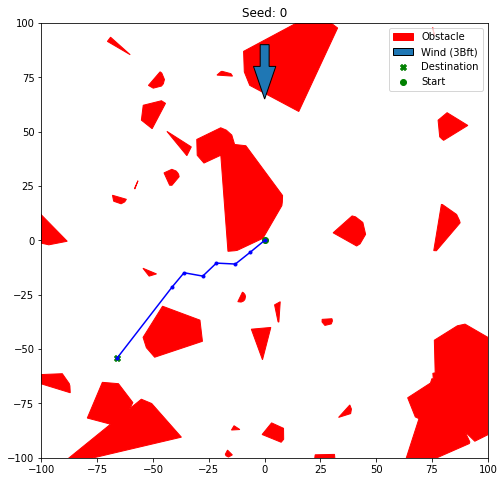

100.1516289789457
TimingFrame([[  0.      0.   ]
 [ -7.598  13.   ]
 [-15.204  26.   ]
 [-22.794  39.   ]
 [-30.408  52.   ]
 [-38.     65.   ]])


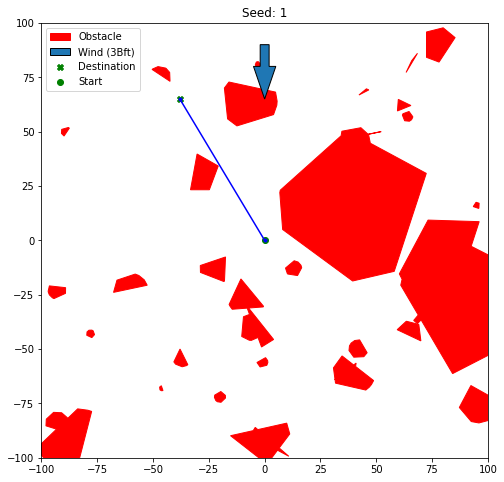

75292.76193632427
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7fa2320>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7fa3400>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7fa2170>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7fdc160>]


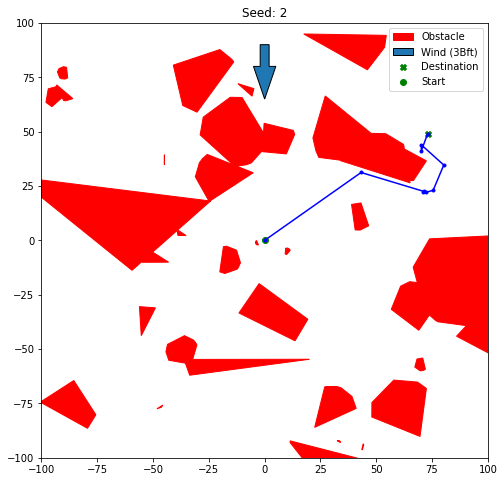

21127.886648066025
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7fe13c0>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7fe1b70>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7fe1f60>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7fe2080>]


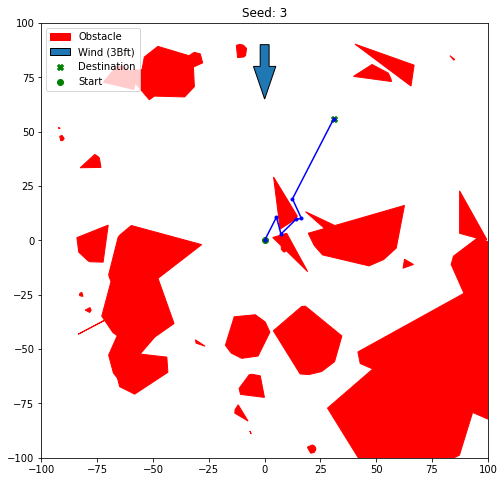

63200.63075818353
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e1fca0>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e1fa60>]


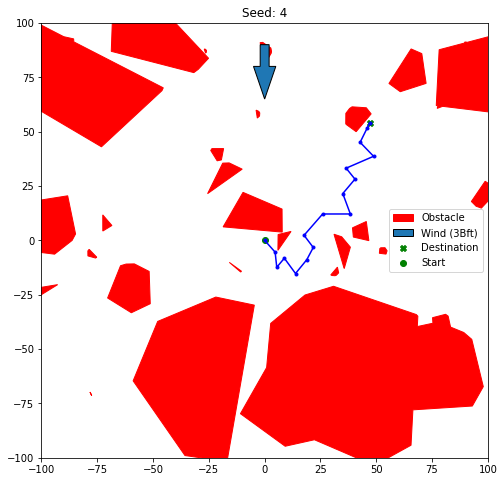

28914.654143248754
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e4fb80>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e4f850>]


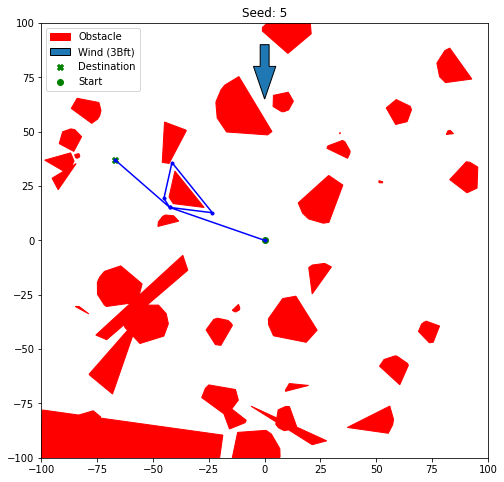

1353.6289597210239
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7d4ad40>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7d496c0>]
Counter exceeded
Counter exceeded


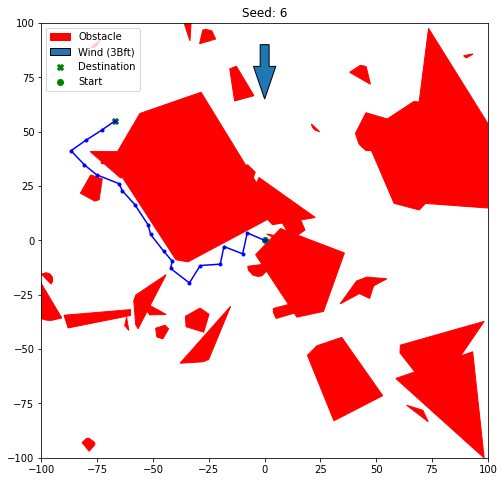

23898.229530915676
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7fe2530>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7fe3d30>]


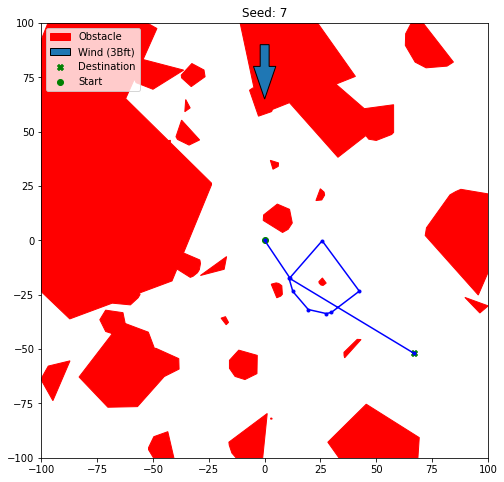

7208.886339146704
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dccce1240>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dccce24a0>]


/pyrate/pyrate/plan/nearplanner/cost_functions.py:131: RuntimeWarning: overflow encountered in double_scalars
  grad = -cost * self.scale * self.safety_dist / dist**2 if dist > 0 else 0


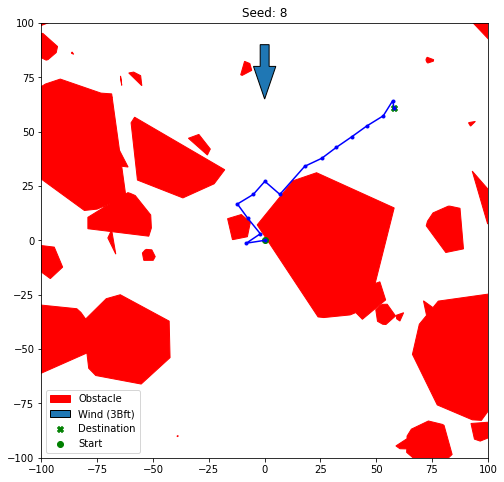

16899.906925933017
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dcc31cbb0>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dcc31d4b0>]
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded


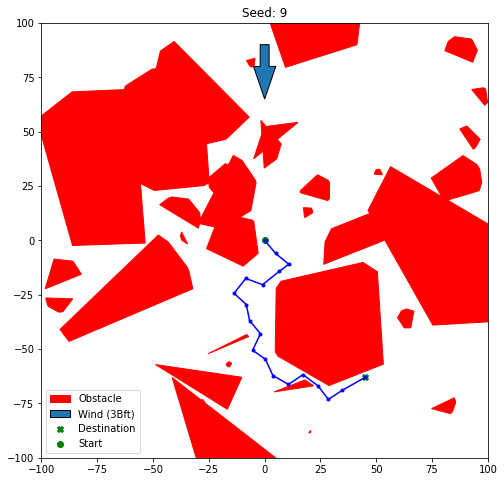

278.78263858129446
TimingFrame([[ 0.     0.   ]
 [ 7.602  9.6  ]
 [15.196 19.2  ]
 [22.806 28.8  ]
 [30.392 38.4  ]
 [38.    48.   ]])


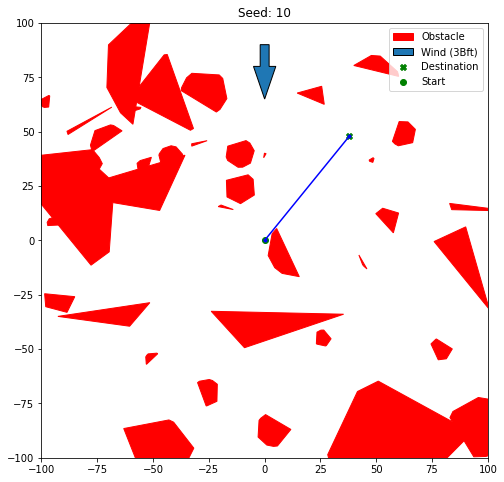

1964.0579135370533
TimingFrame([[  0.      0.   ]
 [ -9.598  -6.2  ]
 [-19.204 -12.4  ]
 [-28.794 -18.6  ]
 [-38.408 -24.8  ]
 [-48.    -31.   ]])


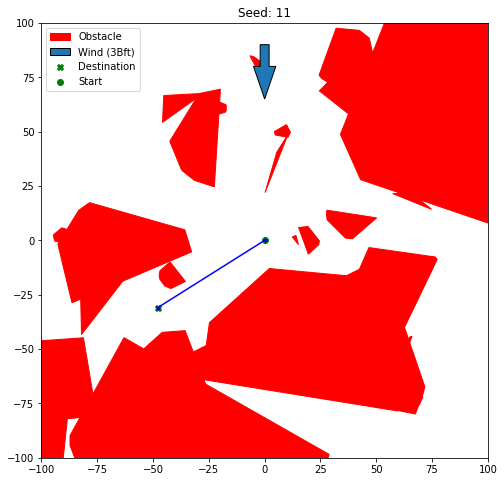

34.83061750362102
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dcc113e50>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dcc113550>]


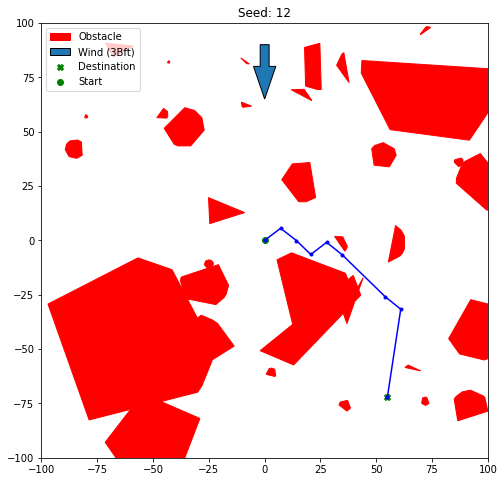

177.41547484529482
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dccce3070>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dccce26b0>]
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded


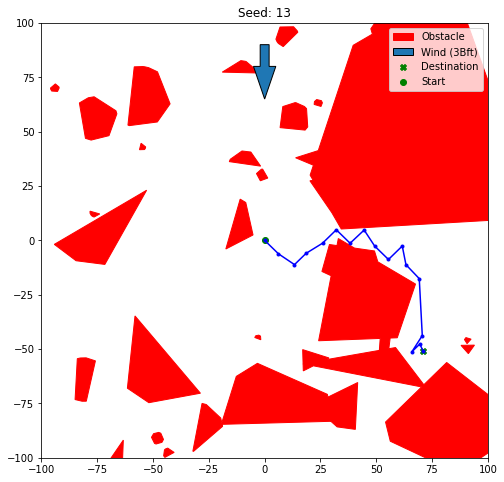

456.6746001056997
TimingFrame([[ 0.     0.   ]
 [ 5.402 12.6  ]
 [10.796 25.2  ]
 [16.206 37.8  ]
 [21.592 50.4  ]
 [27.    63.   ]])


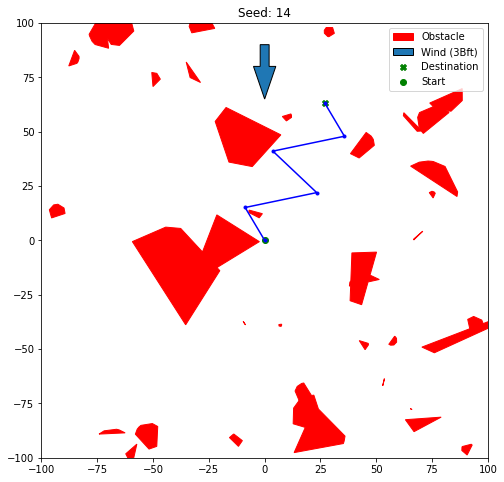

35161.11757008961
TimingFrame([[ 0.     0.   ]
 [13.002 11.6  ]
 [25.996 23.2  ]
 [39.006 34.8  ]
 [51.992 46.4  ]
 [65.    58.   ]])


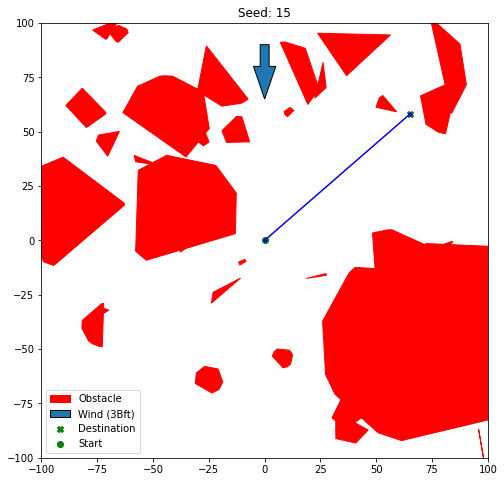

341.3241178992573
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dcc31d000>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dcc04ceb0>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dcc04d090>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dcc04c640>]
Counter exceeded


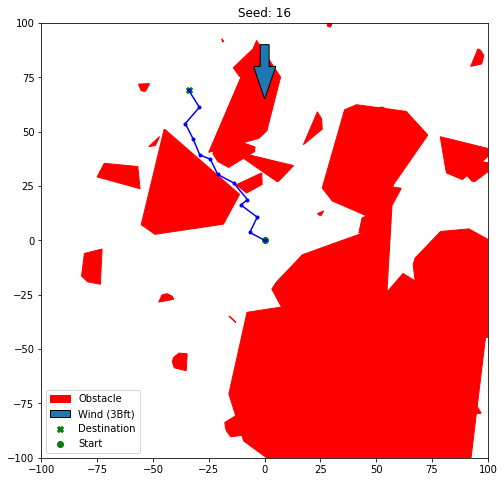

41109.985511861494
TimingFrame([[ 0.     0.   ]
 [ 7.202 13.6  ]
 [14.396 27.2  ]
 [21.606 40.8  ]
 [28.792 54.4  ]
 [36.    68.   ]])


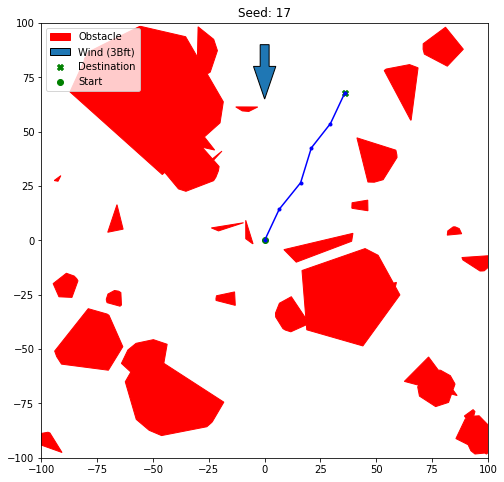

49514.429198192825
TimingFrame([[  0.      0.   ]
 [ -6.598 -11.2  ]
 [-13.204 -22.4  ]
 [-19.794 -33.6  ]
 [-26.408 -44.8  ]
 [-33.    -56.   ]])


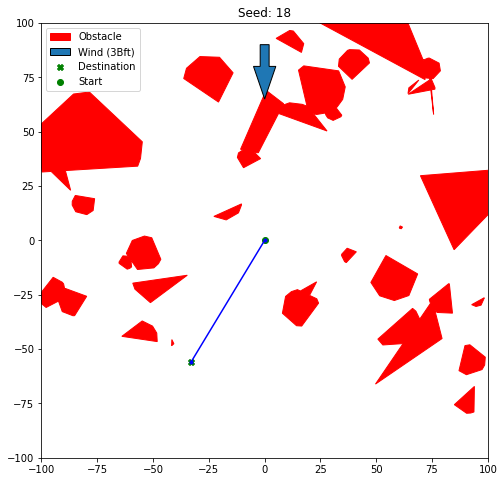

43.41167447673334
TimingFrame([[  0.      0.   ]
 [ -4.998   6.6  ]
 [-10.004  13.2  ]
 [-14.994  19.8  ]
 [-20.008  26.4  ]
 [-25.     33.   ]])


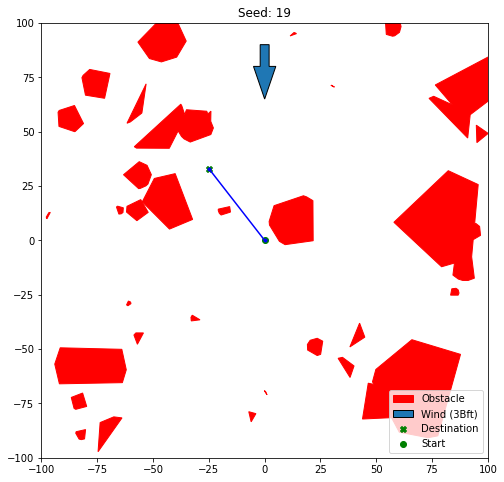

3001.9634422490617


In [12]:
def plot_situation(
    obstacles: dict[str, Polygon],
    destination: Point,
    obstacle_color: Optional[str] = None,
    route: Optional[TimingFrame] = None,
    legend: bool = True,
    title: Optional[str] = None,
) -> None:
    """PLots the obstacles into a matplotlib plot.

    Args:
        obstacles: A list of obstacles.
        destination: The destination that should be reached by the boat.
        obstacle_color: The color the obstacles should have. Can be None.
        If none all obstacles will have different colors.
        route: The route that should be plotted.
        legend: If true plots a legend.
        title: The title of the plot.
    Returns:
        None
    """
    plt.figure(figsize=(8, 8))
    plt.axis([-SIZE_ROUTE, SIZE_ROUTE, -SIZE_ROUTE, SIZE_ROUTE])

    # Sets a title if one is demanded
    if title:
        plt.title(title)

    # Plots the obsticles.
    if obstacles:
        for polygon in obstacles.values():
            if obstacle_color is not None:
                plt.fill(*polygon.exterior.xy, color=obstacle_color, label="Obstacle")
            else:
                plt.fill(*polygon.exterior.xy)

    # Plots the wind direction
    # https://www.geeksforgeeks.org/matplotlib-pyplot-arrow-in-python/
    plt.arrow(
        0,
        +int(SIZE_ROUTE * 0.9),
        0,
        -int(SIZE_ROUTE * 0.1),
        head_width=10,
        width=4,
        label="Wind (3Bft)",
    )

    if route:
        plt.plot(route.points[:, 0], route.points[:, 1], color="BLUE", marker=".")

    # Plots the estination
    if destination:
        plt.scatter(*destination.xy, marker="X", color="green", label="Destination")
    plt.scatter(0, 0, marker="o", color="green", label="Start")

    if legend:
        # https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
    plt.show()


# for seed in tqdm(range(0, 30, 1)):
for seed in tqdm(range(0, 20, 1)):
    wind_dir = 180
    obstacles = generate_obstacles(seed)
    destination = generate_destination(obstacles, seed)
    route = None
    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, wind_dir),
        )
    except Exception as e:
        print("Error")
        print(e)
        route = None
    plot_situation(
        obstacles=obstacles,
        destination=destination,
        obstacle_color="RED",
        route=route,
        title=f"Seed: {seed}",
    )
    print(route.cost)

[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dccc9b370>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dccc99420>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dccc9b280>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dccc9bc10>]


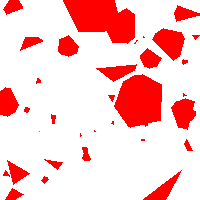

In [13]:
def generate_image_from_map(
    obstacles: dict[str, Polygon],
    destination: Point,
    route: Optional[TimingFrame] = None,
) -> Image:
    """Generate an image from the map.

    Can be used to feed an ANN.
    - Obstacles are marked as reed.
    - The destination is marked as green.
    - The points where the route will likely change are blue.

    Args:
        obstacles: A dict of obstacles as shapely Polygons. Keyed as a string.
        destination: A destination that should be navigated to.
    """
    img = Image.new(
        "RGB",
        (SIZE_ROUTE * 2, SIZE_ROUTE * 2),
        "#ffffff",
    )
    draw = ImageDraw.Draw(img)
    for polygon in obstacles.values():
        draw.polygon(
            list(np.dstack(polygon.exterior.xy).reshape((-1)) + SIZE_ROUTE),
            fill="#FF0000",
            outline="#FF0000",
        )
    img.putpixel((int(destination.x) + 100, int(destination.y) + 100), (0, 0xFF, 0))
    return img


seed = 42
wind_dir = 180
obstacles = generate_obstacles(seed)
destination = generate_destination(obstacles, seed)
route = None
try:
    route, _ = experiments.generate_route(
        position=Point(0, 0), goal=destination, obstacles=obstacles, wind=(18, wind_dir)
    )
except Exception as e:
    print("Error")
    print(e)
    route = None
generate_image_from_map(
    obstacles=obstacles,
    destination=destination,
    route=route,
)

In [14]:
def generate_all_to_series(
    seed: Optional[int] = None, image: bool = False
) -> pd.Series:
    """Generates everything and aggregates all data into a `pd:Series`.

    Args:
        seed:The seed that should be used to generate map and destination.
        image: If an image should be generated or if that should be postponed to save memory.
    Returns:
        Contains a `pd.Series`containing the following.
        - The seed tha generated the map.
        - The destination in x
        - The destination in y
        - A list of Obstacle polygons.
        - The route generated for this map by the roBOOTer navigation system.
        - Optionally the image containing all the information.
          Can be generated at a later date without the fear for a loss of accuracy.
    """
    obstacles = generate_obstacles(seed)
    destination = generate_destination(obstacles, seed)

    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, wind_dir),
        )
    except Exception as e:
        print("Error")
        print(e)
        route = None
    return pd.Series(
        data={
            "seed": str(seed),
            "obstacles": obstacles,
            "destination_x": destination.x,
            "destination_y": destination.y,
            "image": generate_image_from_map(obstacles, destination, route)
            if image
            else pd.NA,
            "route": route.points if route else pd.NA,
            "cost": route.cost if route else pd.NA,
        },
        name=str(seed),
    )

In [15]:
df = pd.DataFrame(
    [generate_all_to_series(i, image=False) for i in tqdm(range(5))]
).set_index("seed")
df.to_pickle("test.pickle")
df

  0%|          | 0/5 [00:00<?, ?it/s]

[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dcc162f80>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dccc80820>]
TimingFrame([[  0.      0.   ]
 [ -7.598  13.   ]
 [-15.204  26.   ]
 [-22.794  39.   ]
 [-30.408  52.   ]
 [-38.     65.   ]])
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e4db10>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e4f610>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e4c1c0>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e4f2b0>]
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7df81c0>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7dfa3e0>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7df9d20>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7df8be0>]
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7dfb010>, <pyrate.plan.nearplan

obstacles  destination_x  \
seed                                                                     
0     {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
1     {'0': POLYGON ((-97.82715137072381 -82.2211677...          -38.0   
2     {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
3     {'0': POLYGON ((-7.4210414351932155 -83.111096...           31.0   
4     {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   

      destination_y image                                              route  \
seed                                                                           
0             -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
1              65.0  <NA>                        [[0.0, 0.0], [-38.0, 65.0]]   
2              49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
3              56.0  <NA>  [[0.0, 0.0], [5.303962239032221, 10.6856391688...   
4              54.0  <NA>  [[0.0, 0.0], [4.691900284503645, -5.4114328014...   

              cost  
seed                
0       100.151629  
1     75292.761936  
2     21127.886648  
3     63200.630758  
4     28914.654143

https://programtalk.com/python-examples/PIL.ImageDraw.Draw.polygon/)
https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask

In [16]:
save_frequency = int(os.getenv("save_frequency", "50"))
start_seed = int(os.getenv("seed_start", "0"))
continues = bool(os.getenv("continues", "true"))

files = glob.glob("data/*.pickle")
seed_groups = {int(file[9:-7]) for file in files}
for next_seeds in range(start_seed, 10_000_000_000, save_frequency):
    if next_seeds in seed_groups:
        continue
    print(f"Start generating routes for seed: {next_seeds}")
    tmp_pickle_str: str = f"data/tmp_{next_seeds:010}.pickle"
    pd.DataFrame().to_pickle(tmp_pickle_str)
    df = pd.DataFrame(
        [
            generate_all_to_series(i, image=False)
            for i in tqdm(range(next_seeds, next_seeds + save_frequency, 1))
        ]
    ).set_index("seed")
    pickle_to_file = f"data/raw_{next_seeds:010}.pickle"
    df.to_pickle(pickle_to_file)
    os.remove(tmp_pickle_str)
    if not continues:
        break

Start generating routes for seed: 100


  0%|          | 0/50 [00:00<?, ?it/s]

TimingFrame([[  0.      0.   ]
 [-14.598   9.2  ]
 [-29.204  18.4  ]
 [-43.794  27.6  ]
 [-58.408  36.8  ]
 [-73.     46.   ]])
TimingFrame([[  0.      0.   ]
 [  7.002 -14.   ]
 [ 13.996 -28.   ]
 [ 21.006 -42.   ]
 [ 27.992 -56.   ]
 [ 35.    -70.   ]])
TimingFrame([[  0.      0.   ]
 [-14.198   7.4  ]
 [-28.404  14.8  ]
 [-42.594  22.2  ]
 [-56.808  29.6  ]
 [-71.     37.   ]])
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e1e590>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e1e620>]
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e1e2c0>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7e1d4b0>]
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7974b20>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc79765f0>]
TimingFrame([[ 0.     0.   ]
 [14.402  8.4  ]
 [28.796 16.8  ]
 [43.206 25.2  ]
 [57.592 33.6  ]
 [72.    42.   ]])
[<pyrate.plan.nearplanner.timing_fr

TimingFrame([[  0.      0.   ]
 [ -8.398  10.4  ]
 [-16.804  20.8  ]
 [-25.194  31.2  ]
 [-33.608  41.6  ]
 [-42.     52.   ]])
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7c48eb0>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7c4bd90>]
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
Counter exceeded
TimingFrame([[ 0.     0.   ]
 [ 9.602 14.2  ]
 [19.196 28.4  ]
 [28.806 42.6  ]
 [38.392 56.8  ]
 [48.    71.   ]])
[<pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7bbf100>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7bbc6d0>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7bbd870>, <pyrate.plan.nearplanner.timing_frame.TimingFrame object at 0x7f0dc7bbc850>]
TimingFrame([[  0.      0.   ]
 [-10.398  -9.   ]
 [-20.804 -18.   ]
 [-31.194 -27.   ]


In [17]:
pd.read_pickle(pickle_to_file)

obstacles  destination_x  \
seed                                                                     
100   {'0': POLYGON ((3.068164294574821 -111.1117632...          -73.0   
101   {'0': POLYGON ((-73.8299498909983 -100.4603262...           35.0   
102   {'0': POLYGON ((-48.56089600298081 -91.2532819...          -71.0   
103   {'0': POLYGON ((-91.62253072553011 -99.6000824...          -54.0   
104   {'0': POLYGON ((-30.301442374804513 -119.17178...           52.0   
105   {'0': POLYGON ((-13.98026154677405 -91.7485098...           42.0   
106   {'0': POLYGON ((-82.54936306785496 -93.7217051...           72.0   
107   {'0': POLYGON ((-63.94552500954688 -86.4149817...          -59.0   
108   {'0': POLYGON ((-76.94237469566472 -78.0003939...           41.0   
109   {'0': POLYGON ((-10.865095574923775 -102.54100...          -42.0   
110   {'0': POLYGON ((0.8898241350950777 -89.9936751...          -60.0   
111   {'0': POLYGON ((-98.72556039040491 -71.7387588...          -62.0   
112   {'0': POLYGON ((-91.20905560584092 -115.015802...          -35.0   
113   {'0': POLYGON ((-3.029890965964797 -90.3750911...          -73.0   
114   {'0': POLYGON ((-71.05046551549411 -49.6489258...           29.0   
115   {'0': POLYGON ((-53.030225769587304 -94.045042...           69.0   
116   {'0': POLYGON ((-25.904098317638375 -93.474680...          -26.0   
117   {'0': POLYGON ((-39.4374182246976 -87.24459167...          -49.0   
118   {'0': POLYGON ((-15.836926938981108 -87.749041...          -75.0   
119   {'0': POLYGON ((-124.7269776269041 -86.3669172...          -61.0   
120   {'0': POLYGON ((-15.028539407969866 -91.230797...           30.0   
121   {'0': POLYGON ((-84.02679630621084 -100.128997...          -29.0   
122   {'0': POLYGON ((-97.90683011740342 -79.7683567...           33.0   
123   {'0': POLYGON ((-5.943476326809584 -90.8542322...           34.0   
124   {'0': POLYGON ((-23.316798146294683 -77.096118...          -58.0   
125   {'0': POLYGON ((-57.54193937039286 -89.4702280...           35.0   
126   {'0': POLYGON ((-19.55031944851535 -93.0966180...           27.0   
127   {'0': POLYGON ((-2.7832769492154643 -83.960855...           65.0   
128   {'0': POLYGON ((-80.50259540651334 -63.9812192...           44.0   
129   {'0': POLYGON ((-54.42762661013539 -70.0826612...           38.0   
130   {'0': POLYGON ((-24.525836344188384 -72.208162...           42.0   
131   {'0': POLYGON ((-93.43860495071749 -79.9222618...           30.0   
132   {'0': POLYGON ((-42.09155263618429 -87.3627291...           74.0   
133   {'0': POLYGON ((-53.276884100947974 -98.800599...           32.0   
134   {'0': POLYGON ((-50.72260286408097 -19.9374970...          -37.0   
135   {'0': POLYGON ((-74.71402718666764 -114.426610...          -47.0   
136   {'0': POLYGON ((-15.770573247641416 -107.49759...          -73.0   
137   {'0': POLYGON ((-87.28281036146248 -75.6304517...          -27.0   
138   {'0': POLYGON ((-45.03638683312978 -95.7985867...           42.0   
139   {'0': POLYGON ((-70.85168811441109 -95.7518007...           52.0   
140   {'0': POLYGON ((-53.68466165592503 -111.857668...           28.0   
141   {'0': POLYGON ((-89.65481529001046 -92.2475036...           43.0   
142   {'0': POLYGON ((-70.79146217666272 -55.2497557...          -26.0   
143   {'0': POLYGON ((-38.871939154105725 -100.58623...          -42.0   
144   {'0': POLYGON ((-107.59666030553088 -118.77390...           28.0   
145   {'0': POLYGON ((-46.70179950750857 -83.5923427...           48.0   
146   {'0': POLYGON ((-55.26784992451735 -93.6100833...           40.0   
147   {'0': POLYGON ((-26.112695030917337 -92.894211...          -52.0   
148   {'0': POLYGON ((4.349420058841754 -75.99892130...           70.0   
149   {'0': POLYGON ((-47.05087697636738 -89.7051401...          -32.0   

      destination_y image                                              route  \
seed                                                                           
100            46.0  <NA>            

Ich würde auch zu 1. tendieren, stimme Ihnen aber zu, dass das Thema sehr umfangreich ist. Könnte man sich nicht einen Teilbereich herauspicken? Ich verstehe nicht viel vom Segeln, daher lassen Sie mich kurz zusammenfassen, was Sie vorhaben: - Sie generieren Trainingsdaten mit dem existierenden aber langsamen GD Algorithmus. Ich nehme an, es handelt sich um lokale Routen in einem relativ kleinen Kartenausschnitt. Lässt es die Laufzeit zu, dass Sie eine große Menge an Routen berechnen. - Sie haben dann eine Karte und als Ausgabe eine Liste der Wendepunkte - Warum wollen Sie daraus eine Heatmap berechnen? Diesen Schritt habe ich noch nicht verstanden - Wenn Sie aus einer Karte eine Heatmap trainieren wollen und dafür genügend Beispiele haben, könnnten GANs hilfreich sein: https://arxiv.org/abs/1611.07004 Ich würde Ihnen raten, das Problem möglichst so zu reduzieren, dass es im Rahmen des Moduls noch handhabbar bleibt. Alles Weitere kann man sich auch für spätere Arbeiten aufbewahren. Das 2. Thema ist auch ok. Aber vielleicht nicht ganz so spannend. Ich überlasse Ihnen die Entscheidung. Freundliche Grüße Heiner Giefers

In [18]:
from shapely.wkt import loads
from shapely.wkt import loads
from shapely.validation import explain_validity
from shapely.geometry.polygon import LinearRing

l = loads(
    "LINESTRING (9603380.577551289 2719693.31939431, 9602238.01822002 2719133.882441244, 9601011.900844947 2718804.012436028, 9599670.800095448 2718931.680117098, 9599567.204161201 2717889.384686942, 9600852.184025297 2721120.409265322, 9599710.80929024 2720511.270897166, 9602777.832940497 2718125.875545334)"
)

print(l.is_simple)  # False

False


In [19]:
ring = LinearRing(list(l.coords))

print(ring.is_simple)  # False
print(
    explain_validity(ring)
)  # Ring Self-intersection[9600397.5202531 2719977.17748099]

False
Ring Self-intersection[9601676.14644973 2718982.71857426]
